# Importing Necessities

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'            
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt


# Loading data

In [7]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

Removing the string version of education column since its redundant

In [8]:
train['education'] = train['educational-num']
test['education'] = test['educational-num']
train = train.drop(columns=['educational-num'], axis=1)
test = test.drop(columns=['educational-num'], axis=1)

# Inspecting data and perform feature enginnering

In [9]:
train_null, test_null = [], []
print('=== Train Data ===')
for col in train.columns:
    x = set(train[col])
    y = train[col].isnull().sum()
    train_null.append(col) if y != 0 else None
    print(f'[{col}] unique data: {len(x)}. with {y} nulls')

print()
print('=== Test Data ===')
for col in test.columns:
    x = set(train[col])
    y = train[col].isnull().sum()
    test_null.append(col) if y != 0 else None
    print(f'[{col}] unique data: {len(x)}. with {y} nulls')
    
print()
print(f'Train data with null: {train_null}')
print(f'Test data with null: {test_null}')

=== Train Data ===
[age] unique data: 74. with 0 nulls
[workclass] unique data: 9. with 2498 nulls
[fnlwgt] unique data: 26646. with 0 nulls
[education] unique data: 16. with 0 nulls
[marital-status] unique data: 7. with 0 nulls
[occupation] unique data: 15. with 2506 nulls
[relationship] unique data: 6. with 0 nulls
[race] unique data: 5. with 0 nulls
[gender] unique data: 2. with 0 nulls
[capital-gain] unique data: 122. with 0 nulls
[capital-loss] unique data: 97. with 0 nulls
[hours-per-week] unique data: 94. with 0 nulls
[native-country] unique data: 42. with 763 nulls
[income_>50K] unique data: 2. with 0 nulls

=== Test Data ===
[age] unique data: 74. with 0 nulls
[workclass] unique data: 9. with 2498 nulls
[fnlwgt] unique data: 26646. with 0 nulls
[education] unique data: 16. with 0 nulls
[marital-status] unique data: 7. with 0 nulls
[occupation] unique data: 15. with 2506 nulls
[relationship] unique data: 6. with 0 nulls
[race] unique data: 5. with 0 nulls
[gender] unique data: 

At this phase, we will drop the row with null value since there is not much and we believe that we will still need the column to increase our model accuracy. Aside from dropping null columns, we will also categorize several columns with 'string-based class data'. After finishing the data transforming, finally we will rename our target column accordingly and inspect our table.

In [10]:
train=train.dropna()
test=test.dropna()

def dictionarize(data):
    temp = set(data)
    return { j:i+1 for i,j in enumerate(temp)}

columns_to_classify = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

for col in columns_to_classify:
    temp_dict = dictionarize(train[col])
    train[col] = [temp_dict[i] for i in train[col]]
    test[col] = [temp_dict[i] for i in test[col]]

train.rename(columns={'income_>50K':'target'}, inplace=True)

train.head()

<ipython-input-10-2cbcc89e71b7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = [temp_dict[i] for i in train[col]]


,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,target
0,67,6,366425,16,3,5,6,1,2,99999,0,60,24,1
1,17,6,244602,8,2,1,1,1,2,0,0,15,24,0
2,31,6,174201,13,4,5,5,1,2,0,0,40,24,1
3,58,4,110199,4,4,4,5,1,2,0,0,40,24,0
4,25,4,149248,10,2,1,6,4,2,0,0,40,24,0


### PS: Data Note
We will use the splitted train data since the actual test data doesn't have the target column provided so we are not able to perform evaluation later to our prediction data.

In [11]:
x = train.drop(columns=['target'], axis=1)
y = train['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.125)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [12]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(28508, 13) (28508,)
(8146, 13) (28508,)
(4073, 13) (4073,)


# Building and Training Model
As for our model, we will use a model base from [tensorflow's keras](https://www.tensorflow.org/guide/keras/sequential_model) and add layers as listed below:
- Input dimension with 13 nodes (therefore coming up with also 13 nodes)
- Hidden layer with 2 nodes
- Output layer with 1 node (the class output)

for our custom model architecture, we will make the architecture as listed below:
- Input dimension with 13 nodes (also coming up with 13 node)
- Batch Normalization Layer
- Fully connected layer with 32 nodes
- Batch Normalization layer
- Fully connected layer with 16 nodes
- Output layer with 1 node

With every layer have `kernel_initializer` parameter that will determine how the initializing weight happened and also activation function (ReLu, ad sigmoid activation for classification output). Also, we have `adam` optimizer, with `binary_crossentropy` loss function and `accuracy` metric.

With the configuration above, we will running the model training for 20 epochs, with batch size of 10.

In [13]:
base_model = Sequential()
base_model.add(Dense(13, input_dim=13, activation='relu'))
base_model.add(Dense(2, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()


cust_model = Sequential()
cust_model.add(Dense(13, kernel_initializer='he_uniform', input_dim=13, activation='relu'))
cust_model.add(BatchNormalization())
cust_model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
cust_model.add(BatchNormalization())
cust_model.add(Dense(16, kernel_initializer='he_uniform', activation='relu'))
cust_model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
cust_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cust_model.summary()

base_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=20)
print('='*50)
cust_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 2)                 28        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 13)                182       
                                                                 
 batch_normalization (BatchN  (None,

# Model Training Evaluation
At this section, we will retrieve loss (in both train and validation) from both of our model, as well as the accuracy result to be plotted later. we will see the training metrics plot comparison over epochs.

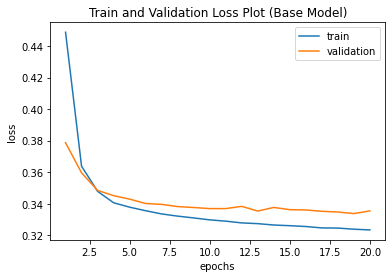

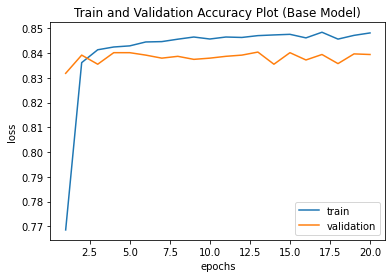

In [14]:
train_loss = base_model.history.history['loss']
valid_loss = base_model.history.history['val_loss']
train_acc = base_model.history.history['accuracy']
valid_acc = base_model.history.history['val_accuracy']
epochs = len(train_loss)

plt.plot(range(1,epochs+1), train_loss, label='train')
plt.plot(range(1,epochs+1), valid_loss, label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot (Base Model)')
plt.legend()
plt.show()

plt.plot(range(1,epochs+1), train_acc, label='train')
plt.plot(range(1,epochs+1), valid_acc, label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Accuracy Plot (Base Model)')
plt.legend()
plt.show()

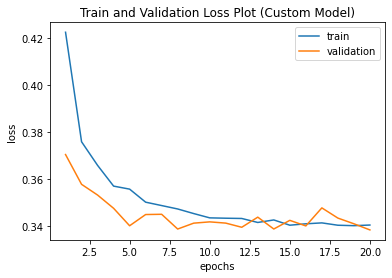

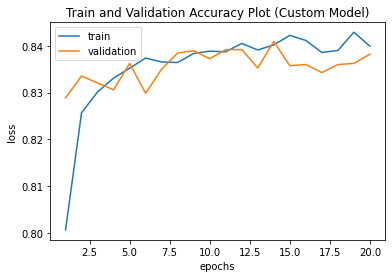

In [15]:
train_loss = cust_model.history.history['loss']
valid_loss = cust_model.history.history['val_loss']
train_acc = cust_model.history.history['accuracy']
valid_acc = cust_model.history.history['val_accuracy']
epochs = len(train_loss)

plt.plot(range(1,epochs+1), train_loss, label='train')
plt.plot(range(1,epochs+1), valid_loss, label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot (Custom Model)')
plt.legend()
plt.show()

plt.plot(range(1,epochs+1), train_acc, label='train')
plt.plot(range(1,epochs+1), valid_acc, label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Accuracy Plot (Custom Model)')
plt.legend()
plt.show()

# Model Evaluation Toward Test Data
At this last section, we will predict the actual test data using the model. At this last evaluation, we will show:
- Prediction and ground truth samples (raw data showcase, up to 20 datas)
- Accuracy and F1 score
- Confusion matrix with heatmap

In [16]:
prediction = np.round(base_model.predict(x_test)).flatten().astype(int)

print("=========================================================\n")
print("                    Base Model Result")
print("=========================================================\n")

acc = accuracy_score(y_test, prediction)
print("=========================================================\n")
print("Predicted Class (20 Samples):")
print(prediction[:20])
print("\nGround Truth (20 Samples):")
print(y_test.values[:20])

print("\n=========================================================\n")
accuracy = accuracy_score(y_test, prediction)
accuracy = accuracy*100
print(f"Accuracy: {accuracy}%")

f1 = f1_score(y_test, prediction, average='macro')
print(f"F1 Score: {f1}")

auc = roc_auc_score(y_test, prediction, average='macro')
print(f"AUC Score: {auc}")

print('\n\nClassification Report:')
cr = classification_report(y_test, prediction)
print(cr)

255/255 [==============================] - 0s 1ms/step

                    Base Model Result


Predicted Class (20 Samples):
[1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0]

Ground Truth (20 Samples):
[0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0]


Accuracy: 85.75988215074884%
F1 Score: 0.7971047876807941
AUC Score: 0.7799422172964717


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      6116
           1       0.76      0.63      0.69      2030

    accuracy                           0.86      8146
   macro avg       0.82      0.78      0.80      8146
weighted avg       0.85      0.86      0.85      8146



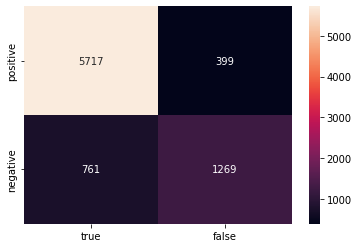

In [17]:
tmp = pd.DataFrame(confusion_matrix(y_test, prediction), index = ['positive', 'negative'], columns = ['true', 'false'])
sns.heatmap(tmp, annot=True, fmt='g')

In [18]:
prediction = np.round(cust_model.predict(x_test)).flatten().astype(int)

print("=========================================================\n")
print("                 Custom Model Result")
print("=========================================================\n")

acc = accuracy_score(y_test, prediction)
print("=========================================================\n")
print("Predicted Class (20 Samples):")
print(prediction[:20])
print("\nGround Truth (20 Samples):")
print(y_test.values[:20])

print("\n=========================================================\n")
accuracy = accuracy_score(y_test, prediction)
accuracy = accuracy*100
print(f"Accuracy: {accuracy}%")

f1 = f1_score(y_test, prediction, average='macro')
print(f"F1 Score: {f1}")

auc = roc_auc_score(y_test, prediction, average='macro')
print(f"AUC Score: {auc}")

print('\n\nClassification Report:')
cr = classification_report(y_test, prediction)
print(cr)

255/255 [==============================] - 0s 2ms/step

                 Custom Model Result


Predicted Class (20 Samples):
[1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0]

Ground Truth (20 Samples):
[0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0]


Accuracy: 85.21973974957035%
F1 Score: 0.7919340419781467
AUC Score: 0.7779906213855605


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6116
           1       0.74      0.63      0.68      2030

    accuracy                           0.85      8146
   macro avg       0.81      0.78      0.79      8146
weighted avg       0.85      0.85      0.85      8146



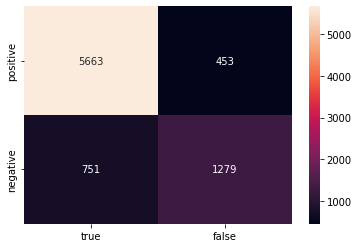

In [19]:
tmp = pd.DataFrame(confusion_matrix(y_test, prediction), index = ['positive', 'negative'], columns = ['true', 'false'])
sns.heatmap(tmp, annot=True, fmt='g')